# Final Project — Medical Tabular Classification (Brain Tumor + Breast Cancer)

**Author:** Leonardo Machado  
**Course:** Stanford Continuing Studies — Applied ML with Python  
**Date:** 2025-08-29

1. Project Title, Problem Statement, Objectives & Goals  
2. Methodology & Block Diagram (pipeline)  
3. Datasets (Brain Tumor)  
4. Data Visualization & Feature Engineering notes  
5. 8 Algorithms:
  5.1) LogReg,
  5.2) SVM-linear
  5.3) SVM-RBF
  5.4) kNN
  5.5) DecisionTree
  5.6) RandomForest
  5.6) GradientBoosting
  5.7) MLP
6. Experiments, Metrics, Comparison Tables/Graphs  
7. Optimization & Test Results
8. Standards/Constraints, Bias/Ethics, Limitations, Conclusion & Future Work


## 0) Setup
Reproducibility, imports, and utility functions.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, recall_score,
                             precision_score, confusion_matrix, classification_report,
                             RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.datasets import load_breast_cancer
import os

#Garantee reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Setting matplotlib styling
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.6
plt.rcParams['grid.linestyle'] = '--'

## 1) Project framing
**Problem Statement:** Tumor detection from image-derived tabular features to support triage.

**Objectives & Goals:**
- Train **8 algorithms** (mix of classical ML + shallow DL).
- Prioritize **Recall (tumor class)** and **ROC-AUC**; include interpretability (coefficients/feature importances).

**Methodology / Pipeline:** Preprocess data → Split (test/validation data) → Pipeline(Scaler→Model) → CV + GridSearch → Test → Plots → Analysis.


## 2) Load Datasets
We use your Brain Tumor CSV and a comparator dataset (Breast Cancer Wisconsin) from scikit-learn.

**Instructions for Colab:**
1. Upload `Brain Tumor.csv` to Colab root (`/content`).
2. If not uploaded, run the upload cell below.

In [2]:
from google.colab import files
#If the file is not already uploaded, upload the dataset
if not os.path.exists('/content/Brain Tumor.csv'):
    print('Upload Brain Tumor.csv...')
    #Upload file
    uploaded = files.upload()

In [3]:
#Define dataset path
bt_path = '/content/Brain Tumor.csv'
#Read dataset into bt variable
bt = pd.read_csv(bt_path)

# Features: drop non-feature column 'Image' and keep 'Class' as target if present
X_bt = bt.drop(columns=[c for c in ['Image','Class'] if c in bt.columns])
y_bt = bt['Class'].astype(int)

# Comparator dataset
bc = load_breast_cancer()
X_bc = pd.DataFrame(bc.data, columns=bc.feature_names)
y_bc = pd.Series(bc.target, name='Class')

print('Brain Tumor shape:', X_bt.shape, ' target n:', y_bt.shape)
print('Breast Cancer shape:', X_bc.shape, ' target n:', y_bc.shape)

# Class balance quick look
print('\nBrain Tumor class counts:\n', y_bt.value_counts())
print('\nBreast Cancer class counts:\n', y_bc.value_counts())

Brain Tumor shape: (3762, 13)  target n: (3762,)
Breast Cancer shape: (569, 30)  target n: (569,)

Brain Tumor class counts:
 Class
0    2079
1    1683
Name: count, dtype: int64

Breast Cancer class counts:
 Class
1    357
0    212
Name: count, dtype: int64


## 3) Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split


def prep_split(X, y, test_size=0.2, seed=RANDOM_STATE):
    # Stratify preserves label ratios in train vs test
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)

X_bt_tr, X_bt_te, y_bt_tr, y_bt_te = prep_split(X_bt, y_bt)
X_bc_tr, X_bc_te, y_bc_tr, y_bc_te = prep_split(X_bc, y_bc)

print('BT train/test:', X_bt_tr.shape, X_bt_te.shape)
print('BC train/test:', X_bc_tr.shape, X_bc_te.shape)

BT train/test: (3009, 13) (753, 13)
BC train/test: (455, 30) (114, 30)


## 4) Models & Hyperparameter Grids (8 total)
We’ll use GridSearchCV (StratifiedKFold=5) and ROC-AUC as the performance metric.

In [5]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

#A dictionary models_grids with 7 Machine Learning Methods
#Pipeline chain pre-processing and the model together
#StandardScaler to standardize features -> especially important for distance-based algorithms

models_grids = {
    'LogReg': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.1,1,10]}
    ),
    'SVM-Linear': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.1,1,10]}
    ),
    'SVM-RBF': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE))]),
        {'clf__C':[0.5,1,5], 'clf__gamma':['scale','auto']}
    ),
    'kNN': (
        Pipeline([('scaler', StandardScaler()),
                  ('clf', KNeighborsClassifier())]),
        {'clf__n_neighbors':[3,5,7,9]}
    ),
    'DecisionTree': (
        DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=RANDOM_STATE),
        {'max_depth':[None,3,5,7], 'min_samples_leaf':[1,3,5]}
    ),
    'RandomForest': (
        RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        {'max_depth':[None,5,10], 'min_samples_leaf':[1,3,5]}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {'learning_rate':[0.05,0.1], 'n_estimators':[150,250], 'max_depth':[2,3]}
    ),
    #Multilayer Perceptron
    'MLP': (
        Pipeline([('scaler', StandardScaler()), ('clf', None)]),
        {}
    )
}

def cv_fit_best(name, estimator, param_grid, Xtr, ytr):
    # Training set is split into 5 folds.
    # StratifiedKFold ensures each fold has the same class balance as the whole dataset.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    # Define a dictionary of cadidate values for each hyperparameter
    # Tries every combination
    # Utilizes ROC_AUC as performance metric. Measures how well the model ranks positive cases above negative cases.
    # Refit=true retrains a fresh model on the entire training set using the best hyperparameters
    gs = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)
    gs.fit(Xtr, ytr)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

def evaluate_on_test(model, Xte, yte):
    y_pred = model.predict(Xte)
    try:
        y_proba = model.predict_proba(Xte)[:,1]
    except Exception:
        dec = model.decision_function(Xte)
        y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)
    metrics = {
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred, zero_division=0),
        'recall': recall_score(yte, y_pred, zero_division=0),
        'f1': f1_score(yte, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(yte, y_proba),
    }
    return metrics, y_pred, y_proba


## 5) Keras MLP (shallow DL)
Feedforward network to complete the 8 algorithms.

In [6]:
# Default number of neurons in the hidden layers = 64
# Dropout rate to reduce overfitting = 10%
def build_mlp(input_dim, hidden=64, dropout=0.1):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    #Sigmoid activation function so output is between 0 and 1
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def run_mlp(Xtr, ytr, Xte, yte, epochs=40, batch=32):
    # Build MLP
    mlp = build_mlp(Xtr.shape[1])
    # Standardize trainning and test data
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)
    # If model does not improve for 5 epochs, model stops early
    es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    hist = mlp.fit(Xtr_s, ytr, validation_split=0.2, epochs=epochs, batch_size=batch, verbose=0, callbacks=[es])
    y_proba = mlp.predict(Xte_s, verbose=0).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    metrics = {
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred, zero_division=0),
        'recall': recall_score(yte, y_pred, zero_division=0),
        'f1': f1_score(yte, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(yte, y_proba),
    }
    return mlp, scaler, hist.history, metrics, y_pred, y_proba


## 6) Run Experiment Suite on Both Datasets
Trains/tunes classical models with CV, runs MLP, collects results, and prints comparison tables.

In [7]:
def run_suite(dataset_name, Xtr, ytr, Xte, yte):
    rows = []
    fitted = {}
    for name, (est, grid) in models_grids.items():
        if name != 'MLP':
            best_model, cv_auc, best_params = cv_fit_best(name, est, grid, Xtr, ytr)
            test_metrics, y_pred, y_proba = evaluate_on_test(best_model, Xte, yte)
            rows.append({'Dataset': dataset_name, 'Model': name, 'CV_ROC_AUC': cv_auc, **test_metrics, 'BestParams': best_params})
            fitted[name] = {'model': best_model, 'y_pred': y_pred, 'y_proba': y_proba}
        else:
            mlp, scaler, history, test_metrics, y_pred, y_proba = run_mlp(Xtr, ytr, Xte, yte)
            rows.append({'Dataset': dataset_name, 'Model': 'MLP', 'CV_ROC_AUC': np.nan, **test_metrics, 'BestParams': {'hidden':64,'dropout':0.1}})
            fitted['MLP'] = {'model': mlp, 'scaler': scaler, 'history': history, 'y_pred': y_pred, 'y_proba': y_proba}
    df = pd.DataFrame(rows).sort_values(['Dataset','roc_auc'], ascending=[True,False]).reset_index(drop=True)
    return df, fitted

bt_results, bt_fitted = run_suite('BrainTumor', X_bt_tr, y_bt_tr, X_bt_te, y_bt_te)
bc_results, bc_fitted = run_suite('BreastCancer', X_bc_tr, y_bc_tr, X_bc_te, y_bc_te)

print('Brain Tumor results:')
display(bt_results)
print('\nBreast Cancer results:')
display(bc_results)

Brain Tumor results:


,Dataset,Model,CV_ROC_AUC,accuracy,precision,recall,f1,roc_auc,BestParams
0,BrainTumor,MLP,NaN,0.990704,0.994012,0.985163,0.989568,0.999586,"{'hidden': 64, 'dropout': 0.1}"
1,BrainTumor,SVM-Linear,0.997477,0.990704,0.991071,0.988131,0.989599,0.999522,{'clf__C': 10}
2,BrainTumor,LogReg,0.998172,0.992032,0.991098,0.991098,0.991098,0.999515,{'clf__C': 10}
3,BrainTumor,GradientBoosting,0.998619,0.992032,1.000000,0.982196,0.991018,0.998630,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
4,BrainTumor,SVM-RBF,0.997971,0.992032,0.994030,0.988131,0.991071,0.998509,"{'clf__C': 5, 'clf__gamma': 'scale'}"
5,BrainTumor,RandomForest,0.997659,0.993360,1.000000,0.985163,0.992526,0.997104,"{'max_depth': None, 'min_samples_leaf': 1}"
6,BrainTumor,kNN,0.995514,0.984064,0.993921,0.970326,0.981982,0.996287,{'clf__n_neighbors': 9}
7,BrainTumor,DecisionTree,0.991136,0.992032,0.996997,0.985163,0.991045,0.990427,"{'max_depth': 7, 'min_samples_leaf': 5}"



Breast Cancer results:


,Dataset,Model,CV_ROC_AUC,accuracy,precision,recall,f1,roc_auc,BestParams
0,BreastCancer,LogReg,0.995769,0.956140,0.985507,0.944444,0.964539,0.995370,{'clf__C': 1}
1,BreastCancer,kNN,0.989938,0.973684,0.960000,1.000000,0.979592,0.994378,{'clf__n_neighbors': 9}
2,BreastCancer,SVM-Linear,0.995666,0.964912,0.985714,0.958333,0.971831,0.994048,{'clf__C': 0.1}
3,BreastCancer,SVM-RBF,0.996285,0.964912,0.985714,0.958333,0.971831,0.994048,"{'clf__C': 1, 'clf__gamma': 'scale'}"
4,BreastCancer,RandomForest,0.992415,0.947368,0.958333,0.958333,0.958333,0.993717,"{'max_depth': None, 'min_samples_leaf': 1}"
5,BreastCancer,MLP,NaN,0.956140,0.971831,0.958333,0.965035,0.992725,"{'hidden': 64, 'dropout': 0.1}"
6,BreastCancer,GradientBoosting,0.993189,0.956140,0.946667,0.986111,0.965986,0.991402,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
7,BreastCancer,DecisionTree,0.955573,0.903509,0.955224,0.888889,0.920863,0.928571,"{'max_depth': 3, 'min_samples_leaf': 5}"


## 7) Plots — Best Model per Dataset
Confusion Matrix and ROC Curve using the recorded predictions.

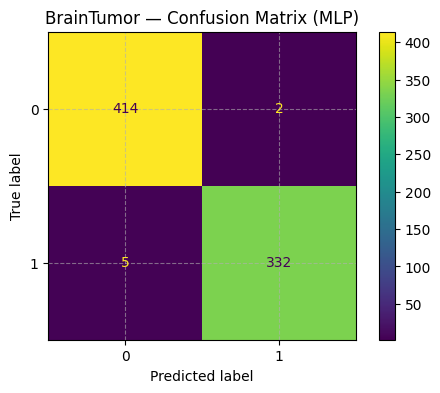

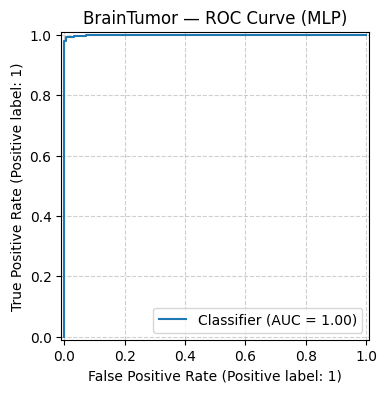

In [8]:
def best_by_auc(results_df):
    return results_df.loc[results_df['roc_auc'].idxmax(), 'Model']

def plot_test_curves(dataset_name, results_df, fitted, Xte, yte):
    best_model_name = best_by_auc(results_df)
    y_pred = fitted[best_model_name]['y_pred']
    y_proba = fitted[best_model_name]['y_proba']

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(yte, y_pred)
    plt.title(f"{dataset_name} — Confusion Matrix ({best_model_name})")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(yte, y_proba)
    plt.title(f"{dataset_name} — ROC Curve ({best_model_name})")
    plt.show()

plot_test_curves('BrainTumor', bt_results, bt_fitted, X_bt_te, y_bt_te)
#plot_test_curves('BreastCancer', bc_results, bc_fitted, X_bc_te, y_bc_te)

## 8) Notes on Standards, Bias/Ethics, Limitations, and Future Work
- **Standards & Constraints:** Reproducibility (seeds), leakage avoidance (pipelines), CV splits (stratified), compute-light.
- **Bias/Ethics/Fairness:** No demographics → subgroup fairness can’t be assessed; risk of false negatives → clinical caution; model is assistive, not diagnostic.
- **Limitations:** Tabular surrogates of images; no external validation; unknown acquisition bias.
- **Future Work:** External validation, threshold tuning for recall, model calibration, raw-image CNNs to replace hand-crafted features.